O churn pode decorrer e, consequentemente ser compreendido através da análise de expectativas negativas e eventuais frustrações do cliente com o produto ou serviço prestado desde o início do seu relacionamento.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

#from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import accuracy_score

from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV

In [2]:
#Dataset
df = pd.read_csv("data/Telco-Customer-Churn.csv")
df.shape

(7043, 21)

In [3]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
# Data Clean

df.isna().sum().sum()

0

No     5174
Yes    1869
Name: Churn, dtype: int64


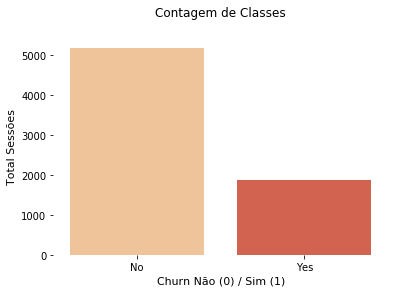

In [5]:

#Verificando o balanceamento
target_count = df.Churn.value_counts()
print(target_count)

# Plot 
sns.countplot(df.Churn, palette = "OrRd")
plt.box(False)
plt.xlabel('Churn Não (0) / Sim (1)', fontsize = 11)
plt.ylabel('Total Sessões', fontsize = 11)
plt.title('Contagem de Classes\n')
plt.show()

In [6]:
# Verificando Valores Únicos
df.nunique()

customerID          7043
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6531
Churn                  2
dtype: int64

In [7]:
# Listas vazias para os resultados
multiple_cols_cat = []
binary_cols = []

# Loop pelas colunas
for c in df.columns[1:]:
    if df.nunique()[c] == 2:
        binary_cols.append(c)
    else:
        multiple_cols_cat.append(c)

In [8]:
multiple_cols_cat

['tenure',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaymentMethod',
 'MonthlyCharges',
 'TotalCharges']

In [9]:
binary_cols

['gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'PhoneService',
 'PaperlessBilling',
 'Churn']

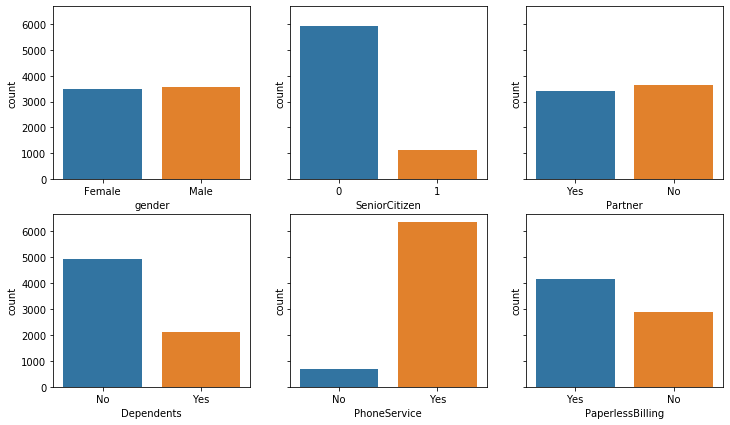

In [10]:
fig, axes = plt.subplots(2, 3, figsize=(12, 7), sharey=True)


sns.countplot(binary_cols[0], data=df, ax=axes[0,0])
sns.countplot(binary_cols[1], data=df, ax=axes[0,1])
sns.countplot(binary_cols[2], data=df, ax=axes[0,2])
sns.countplot(binary_cols[3], data=df, ax=axes[1,0])
sns.countplot(binary_cols[4], data=df, ax=axes[1,1])
sns.countplot(binary_cols[5], data=df, ax=axes[1,2])


In [11]:
#Alterando o campo Churn para 0 ou 1

churn_numeric = {'Yes':1, 'No':0}
df.Churn.replace(churn_numeric, inplace=True)

In [12]:
df[['gender','Churn']].groupby(['gender']).mean()
#O sexo está muito balanceado, então não parece ser um item que influenciaria no modelo

,Churn
gender,
Female,0.269209
Male,0.261603


In [13]:
table = pd.pivot_table(df, values='Churn', index=['gender'],
                    columns=['SeniorCitizen'], aggfunc=np.mean)
table

SeniorCitizen,0,1
gender,,
Female,0.239384,0.422535
Male,0.232808,0.411150


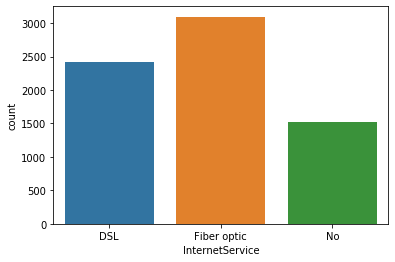

In [14]:
sns.countplot("InternetService", data=df)

In [15]:
df[['InternetService', 'Churn']].groupby('InternetService').mean()

,Churn
InternetService,
DSL,0.189591
Fiber optic,0.418928
No,0.074050


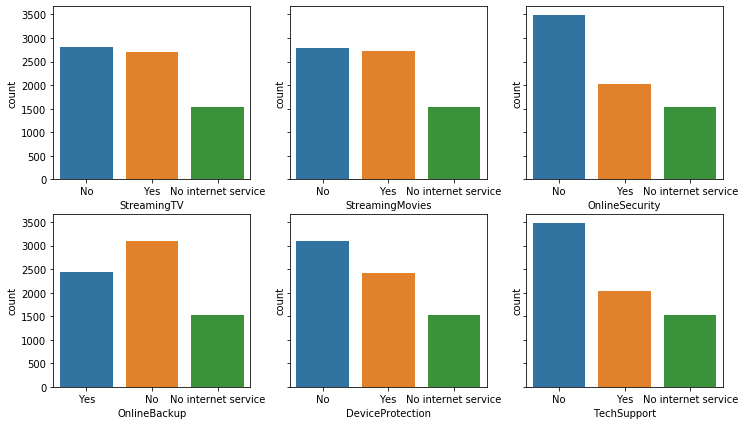

In [16]:
#Distribuição da variável Internet Service com as outras variáveis

fig, axes = plt.subplots(2, 3, figsize=(12, 7), sharey=True)
sns.countplot("StreamingTV", data=df, ax=axes[0,0])
sns.countplot("StreamingMovies", data=df, ax=axes[0,1])
sns.countplot("OnlineSecurity", data=df, ax=axes[0,2])
sns.countplot("OnlineBackup", data=df, ax=axes[1,0])
sns.countplot("DeviceProtection", data=df, ax=axes[1,1])
sns.countplot("TechSupport", data=df, ax=axes[1,2])

In [17]:
df.PhoneService.value_counts()

Yes    6361
No      682
Name: PhoneService, dtype: int64

In [18]:
#Caso um cliente não tenha serviço de telefone ele não terá como ter múltiplas linhas telefônicas
#Como a coluna Multriplas linhas tem dados mais específicos não incluirei a coluna PhoneService, pois posso entender o número de pessoas que têm serviço telefônico na coluna MultipleLines.

df.MultipleLines.value_counts()

No                  3390
Yes                 2971
No phone service     682
Name: MultipleLines, dtype: int64

In [19]:
df[['MultipleLines', 'Churn']].groupby('MultipleLines').mean()

,Churn
MultipleLines,
No,0.250442
No phone service,0.249267
Yes,0.286099


### Contrato e meio de pagamento

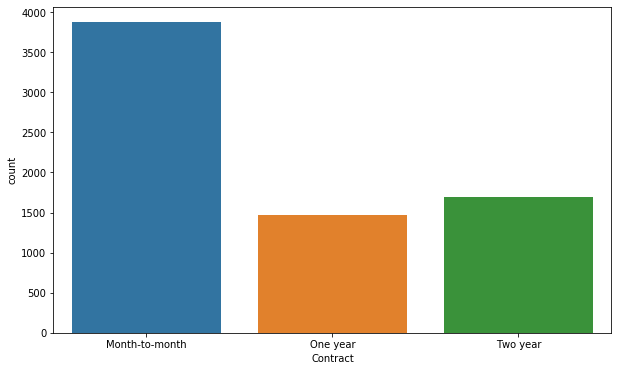

In [20]:
plt.figure(figsize=(10,6))
sns.countplot("Contract", data=df)

In [21]:
df[['Contract', 'Churn']].groupby('Contract').mean()

# Aparentemente quem faz contratos menores estão mais propensos a cancelar.

,Churn
Contract,
Month-to-month,0.427097
One year,0.112695
Two year,0.028319


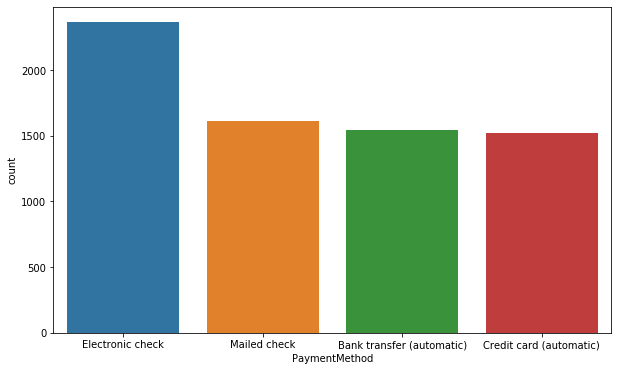

In [22]:
plt.figure(figsize=(10, 6))
sns.countplot("PaymentMethod", data=df)

In [23]:
df[['PaymentMethod', 'Churn']].groupby('PaymentMethod').mean()

#Clientes que pagam com pagamento eletrônico tem uma maior probabilidade de cancelar, mas esse também é o método mais comum utilizado para pagamento.

,Churn
PaymentMethod,
Bank transfer (automatic),0.167098
Credit card (automatic),0.152431
Electronic check,0.452854
Mailed check,0.191067


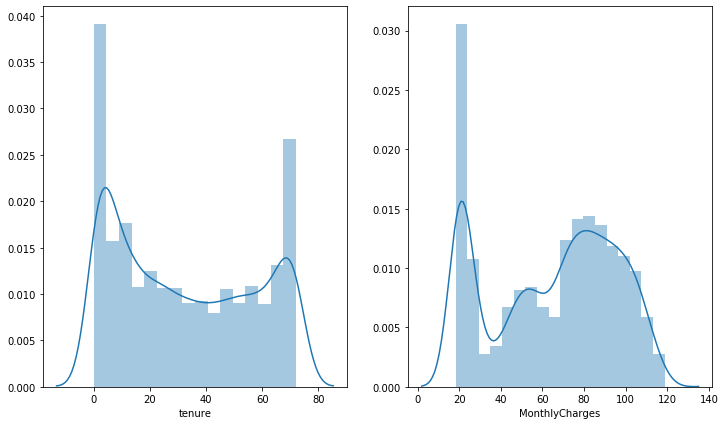

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(12, 7))

sns.distplot(df["tenure"], ax = axes[0])
sns.distplot(df["MonthlyCharges"], ax = axes[1])

In [25]:
df[['tenure', 'MonthlyCharges', 'Churn']].groupby('Churn').mean()

,tenure,MonthlyCharges
Churn,,
0,37.569965,61.265124
1,17.979133,74.441332


In [26]:
df[['Contract', 'tenure']].groupby('Contract').mean()

,tenure
Contract,
Month-to-month,18.036645
One year,42.044807
Two year,56.735103


### Após verificar as variáveis optei por utilizar as seguintes variáveis:

- Customer ID
- Gender
- PhoneService
- Contract
- TotalCharges

In [27]:
df.drop(['customerID', 'gender', 'PhoneService', 'Contract', 'TotalCharges'], axis=1, inplace=True)

## Data Preprocessing

In [28]:
df.nunique()

SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
Churn                  2
dtype: int64

In [29]:
# Listas vazias para os resultados
cat_features = []

# Loop pelas colunas
for c in df.columns[:-1]:
    if df.nunique()[c] <= 5:
        cat_features.append(c)

X = pd.get_dummies(df, columns = cat_features, drop_first = True)

In [30]:
#Escalando as variáveis contínuas

sc = MinMaxScaler()
a = sc.fit_transform(df[['tenure']])
b = sc.fit_transform(df[['MonthlyCharges']])

X['tenure'] = a
X['MonthlyCharges'] = b

In [31]:
X.shape

(7043, 26)

## Resampling

Text(0.5, 1.0, 'Distribuição da classe antes do Resampling')

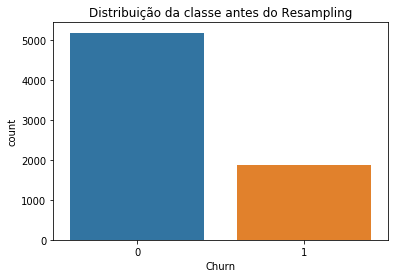

In [32]:
sns.countplot('Churn', data=df).set_title('Distribuição da classe antes do Resampling')

In [33]:
#Separando as classes positivas das negativas

X_no = X[X.Churn == 0]
X_yes = X[X.Churn == 1]

In [34]:
#Upsampling para a classe positiva

X_yes_upsambled = X_yes.sample(n=len(X_no), replace=True)

print(len(X_yes_upsambled))

5174


Text(0.5, 1.0, 'Distribuição da classe após o Resampling')

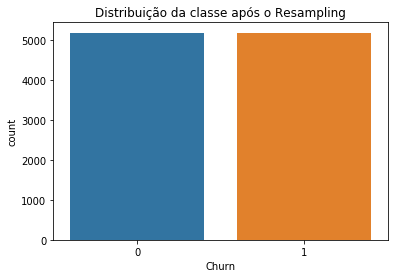

In [35]:
#Combinando classes positivos e negativos e checando a classe de distribuição
X_upsampled = X_no.append(X_yes_upsambled).reset_index(drop = True)

sns.countplot('Churn', data = X_upsampled).set_title('Distribuição da classe após o Resampling')

## Criando e avaliando o modelo

In [36]:
#Divisão de Treino e Teste

X = X_upsampled.drop(['Churn'], axis=1) #features (Variáveis indepedentes)
y = X_upsampled['Churn'] #target (Variáveis dependentes)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

### Random Forest - GridSearchCV

In [38]:
from time import time

# Usando um grid completo de todos os parâmetros
parameters = {"max_depth": [15, 20, 25, None],
              "max_features": [1, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"],
              'n_estimators': [150, 200, 250, 300]}

forest = RandomForestClassifier()

clf = GridSearchCV(estimator = forest, param_grid = parameters, n_jobs = -1, cv = 5)
start = time()
clf.fit(X, y)
print("GridSearchCV executou em %.2f segundos para todas as combinações de candidatos a parâmetros do modelo."
      % (time() - start))

GridSearchCV executou em 595.11 segundos para todas as combinações de candidatos a parâmetros do modelo.


In [45]:
clf.best_score_

0.9081948151105694

In [46]:
clf.best_params_

{'bootstrap': False,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 10,
 'min_samples_leaf': 1,
 'n_estimators': 250}

In [41]:
pd.DataFrame(clf.cv_results_).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_criterion,param_max_depth,param_max_features,param_min_samples_leaf,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.262735,0.005394,0.101197,0.001789,True,gini,15,1,1,150,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.889855,0.893720,0.883092,0.882069,0.893668,0.888481,0.005028,189
1,1.693437,0.015543,0.180388,0.003326,True,gini,15,1,1,200,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.892754,0.896135,0.882609,0.893668,0.889802,0.890994,0.004657,173
2,2.154265,0.007505,0.175119,0.003725,True,gini,15,1,1,250,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.890821,0.896618,0.885507,0.887385,0.886902,0.889447,0.003989,185
3,2.659865,0.042480,0.248543,0.011058,True,gini,15,1,1,300,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.887440,0.899517,0.885990,0.889802,0.888352,0.890220,0.004811,178
4,1.096345,0.008604,0.088845,0.003928,True,gini,15,1,3,150,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.834300,0.845411,0.822705,0.827453,0.819720,0.829918,0.009180,382


In [47]:
previsoes = clf.predict(X_test)
previsoes

array([0, 1, 0, ..., 0, 1, 1])

In [48]:
probabilidades = clf.predict_proba(X_test)
probabilidades

array([[1.   , 0.   ],
       [0.   , 1.   ],
       [1.   , 0.   ],
       ...,
       [1.   , 0.   ],
       [0.375, 0.625],
       [0.   , 1.   ]])

In [49]:
print (accuracy_score(y_test, previsoes))

0.9980676328502416
